Data re-uploading for a universal quantum classifier
[Paper link](https://quantum-journal.org/papers/q-2020-02-06-226/)

In [3]:
from graphix.transpiler import Circuit
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from scipy.optimize import minimize
from functools import reduce
import seaborn as sns
from matplotlib import cm
from IPython.display import clear_output
from time import time

np.random.seed(0)

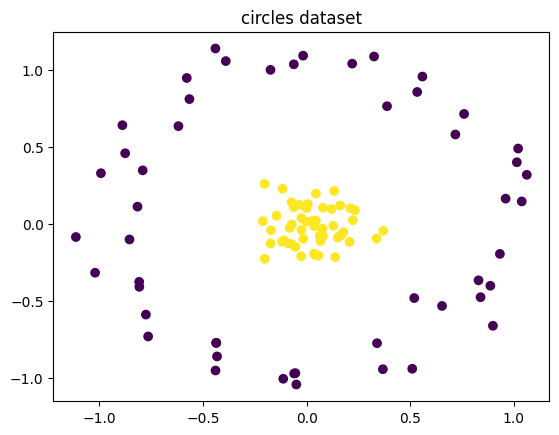

((100, 3), (100,))

In [4]:
x, y = make_circles(n_samples=100, noise=0.1, factor=0.1, random_state=32)

# Plot the circle pattern
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.title('circles dataset')
plt.show()

# pad data
x = np.pad(x, ((0, 0), (0, 1)))

# hinge labels
y = 2*y - 1
x.shape, y.shape


In [5]:
class QNN:
    def __init__(self, n_qubits, n_layers, n_features):
        """
        Initialize uantum neural network with a specified number of
        qubits, layers, and features.

        Args:
          n_qubits: The number of qubits in the quantum circuit.
          n_layers: The number of layers in the quantum circuit.
          n_features: The number of features used in the quantum circuit.
          It must be a multiple of 3.
        """
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.n_features = n_features
        assert n_features % 3 == 0, "n_features must be a multiple of 3"

        # Pauli Z operator on all qubits
        Z_OP = np.array([[1, 0],
                      [0, -1]])
        operator = [Z_OP]*self.n_qubits
        self.obs = reduce(np.kron, operator)
        self.cost_values = [] # to store cost values during optimization

    def rotation_layer(self, circuit, qubit, params, input_params):
        """
        Apply otation gates around the x, y, and z axes to a specified qubit in a
        quantum circuit.

        Args:
          circuit: The quantum circuit on which the rotation layer is applied.
          qubit: The qubit on which the rotation gates are applied.
          params: The `params` variable is a 2D numpy array with shape `(3, 2)`.
          input_params: Feature vector of shape `(3,)`.
        """
        z = params[:, 0]*input_params + params[:, 1]
        circuit.rx(qubit, z[0])
        circuit.ry(qubit, z[1])
        circuit.rz(qubit, z[2])

    def entangling_layer(self, circuit, n_qubits):
        """
        Linear entanglement between qubits in a given circuit.

        Args:
          circuit: The quantum circuit object that the entangling layer will be added to.
          n_qubits: The number of qubits in the quantum circuit.

        Returns:
          If `n_qubits` is less than 2, nothing is returned. Otherwise, the function
        performs a linear entanglement operation on the `n_qubits` qubits in the
        given `circuit` using CNOT gates and does not return anything.
        """
        if n_qubits < 2:
            return

        # Linear entanglement
        for i in range(n_qubits - 1):
            circuit.cnot(i, i + 1)

    def data_reuploading_circuit(self, input_params, params):
        """
        Creates a data re-uploading quantum circuit using the given input parameters and
        parameters for rotation and entangling layers.

        Args:
          input_params: The input data to be encoded in the quantum circuit. It is a 1D
        numpy array of shape `(n_features,)`, where n_features is the number of features
        in the input data.
          params: The `params` parameter is a flattened numpy array containing the values
        of the trainable parameters of the quantum circuit. These parameters are used to
        construct the circuit by reshaping them into a 4-dimensional array of shape
        `(n_layers, n_qubits, n_features, 2)` where `n_layers` is the number of layers in
        the quantum circuit, `n_qubits` is the number of qubits in the quantum circuit,
        `n_features` is the number of features in the input data.

        Returns:
          a quantum circuit object that has been constructed using the input parameters
        and the parameters passed to the function.
        """
        thetas = params.reshape(self.n_layers, self.n_qubits, self.n_features, 2)
        circuit = Circuit(self.n_qubits)
        for l in range(self.n_layers):
            for f in range(self.n_features//3):
                for q in range(self.n_qubits):
                    self.rotation_layer(circuit,
                                        q,
                                        thetas[l][q][3*f:3*(f+1)],
                                        input_params[3*f:3*(f+1)])

            # Entangling layer
            if l < self.n_layers -1:
                self.entangling_layer(circuit, self.n_qubits)

        return circuit

    def get_expectation_value(self, sv):
        """
        Calculates the expectation value of an PauliZ obeservable given a state vector.

        Args:
          sv: sSate vector represented as a numpy array.

        Returns:
          the expectation value of a quantum observable.
        """
        exp_val = self.obs@sv
        exp_val = np.dot(sv.conj(), exp_val)
        return exp_val.real

    def compute_expectation(self, data_point, params):
        """
        Computes the expectation value of a quantum circuit given a data point and
        parameters.

        Args:
          data_point: Input to the quantum circuit represented as a 1D numpy array.
          params: The `params` parameter is a set of parameters that are used to
        construct a quantum circuit. The specific details of what these parameters
        represent is described in  `data_reuploading_circuit` method.

        Returns:
          the expectation value of a quantum circuit, which is computed using the
        statevector of the output state of the circuit.
        """
        circuit = self.data_reuploading_circuit(data_point, params)
        pattern = circuit.transpile()
        pattern.standardize()
        pattern.shift_signals()
        out_state = pattern.simulate_pattern('tensornetwork')
        sv = out_state.to_statevector().flatten()
        return self.get_expectation_value(sv)

    def cost(self, params, x, y):
        """
        Cost function to minimize. The function computes expectation value for each
        data point followed by calculating the mean absolute difference between the
        predicted and actual values. The cost value is also being appended to a list
        called "cost_values"

        Args:
          params: The `params` parameter is a set of parameters that are used to
        construct a quantum circuit. The specific details of what these parameters
        represent is described in  `data_reuploading_circuit` method.
          x: x is a list of input data points used to make predictions.
        Each data point is a list or array of features that the model uses to make
        a prediction.
          y: `y` is a numpy array containing the actual target values for the given
        input data `x`. Each value in `y` is either -1 or 1.

        Returns:
          the cost value
        """
        y_pred = [self.compute_expectation(data_point, params) for data_point in x]
        cost_val = np.mean(np.abs(y - y_pred))
        self.cost_values.append(cost_val)
        return cost_val

    def callback(self, xk):
        """
        Plots the cost values against the number of iterations and displays the plot
        with the latest cost value as a label.

        Args:
          xk: `xk` is a parameter that represents the current value of the optimization
        variable during the optimization process. It is typically a numpy array or a
        list of values. The `callback` function is called at each iteration of the
        optimization process and `xk` is passed as an argument to the function.
        """
        clear_output(wait=True)
        plt.ylabel('Cost')
        plt.xlabel('Iterations')
        cost_val = np.round(self.cost_values[-1],2)
        plt.plot(self.cost_values, color='purple', lw=2, label=f'Cost {cost_val}')
        plt.legend()
        plt.grid()
        plt.show()

    def fit(self, x, y, maxiter=5):
        """
        This function fits the QNN using the COBYLA optimization method with a maximum
        number of iterations and returns the result.

        Args:
          x: The input data for the model. It is a numpy array of shape
        `(n_samples, n_features)`, where `n_samples` is the number of samples and
        `n_features` is the number of features in each sample.
          y: `y` is a numpy array containing the actual target values for the given
        input data `x`. Each value in `y` is either -1 or 1.
          maxiter: Maximum number of iterations that the optimization algorithm will
        perform during the training process. Defaults to 5

        Returns:
          The function `fit` returns the result of the optimization process performed
        by the `minimize` function from the `scipy.optimize` module.
        """
        params = np.random.rand(self.n_layers*self.n_qubits*self.n_features*2)
        res = minimize(self.cost,
                       params,
                       args=(x, y),
                       method='COBYLA',
                       callback=self.callback,
                       options = {'maxiter': maxiter, 'disp':True})
        return res

   NFVALS =   80   F = 4.883464E-01    MAXCV = 0.000000E+00
   X = 1.548814E+00   3.066903E-01   1.735504E+00   1.481102E-01   4.236548E-01
       6.475040E-01   2.590874E-01   7.132732E-01   6.017075E-01   3.848983E-01
       1.791725E+00   1.475303E+00   1.619034E+00   8.470333E-01   8.249985E-01
       1.197311E+00   1.113272E-01   7.722242E-01   2.416107E+00   6.852480E-01
       2.007875E+00   5.093593E-01   4.242657E-01   1.243315E+00


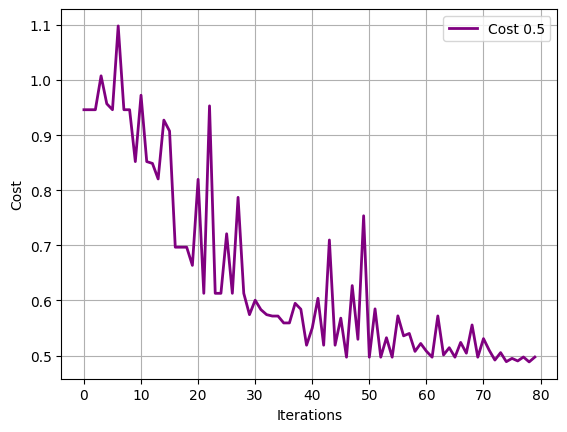

Duration: 140.71249723434448


 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 0.48834643363108055
       x: [ 1.549e+00  3.067e-01 ...  4.243e-01  1.243e+00]
    nfev: 80
   maxcv: 0.0

In [6]:
n_qubits = 2
n_layers = 2
n_features = 3

qnn = QNN(n_qubits, n_layers, n_features)

start = time()
result = qnn.fit(x, y, maxiter=80)
end = time()

print("Duration:", end-start)
result

In [7]:
predictions = np.array([qnn.compute_expectation(data_point, result.x) for data_point in x])
predictions[predictions > 0.0] = 1.0
predictions[predictions <= 0.0] = -1.0
print(np.mean(y == predictions))

0.8


In [8]:
GRID_X_START = -1.5
GRID_X_END = 1.5
GRID_Y_START = -1.5
GRID_Y_END = 1.5

grid = np.mgrid[GRID_X_START:GRID_X_END:20j,GRID_X_START:GRID_Y_END:20j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid
grid_2d = np.pad(grid_2d, ((0, 0), (0, 1)))
predictions = np.array([qnn.compute_expectation(data_point, result.x)
                        for data_point in grid_2d])

print(predictions.shape, XX.shape)


(400,) (20, 20)


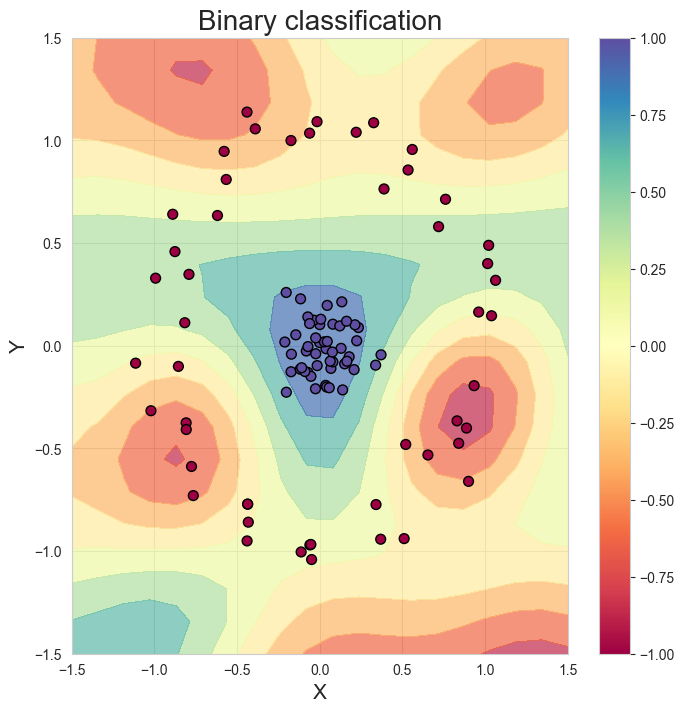

In [9]:
plt.figure(figsize=(8,8))
sns.set_style("whitegrid")
plt.title('Binary classification', fontsize=20)
plt.xlabel('X', fontsize=15)
plt.ylabel('Y', fontsize=15)
plt.contourf(XX, YY, predictions.reshape(XX.shape), alpha = 0.7, cmap=cm.Spectral)
plt.scatter(x[:, 0], x[:, 1], c=y.ravel(), s=50, cmap=plt.cm.Spectral, edgecolors='black')
plt.colorbar()
plt.show()

In [10]:
n_qubits = 2
n_layers = 2
n_features = 3

params = np.random.rand(n_layers * n_qubits * n_features * 2)
input_params = np.random.rand(n_features)

qnn = QNN(n_qubits, n_layers, n_features)
circuit = qnn.data_reuploading_circuit(input_params, params)
pattern = circuit.transpile(opt=False)
pattern.standardize()
pattern.shift_signals()

print(pattern.max_space())

36


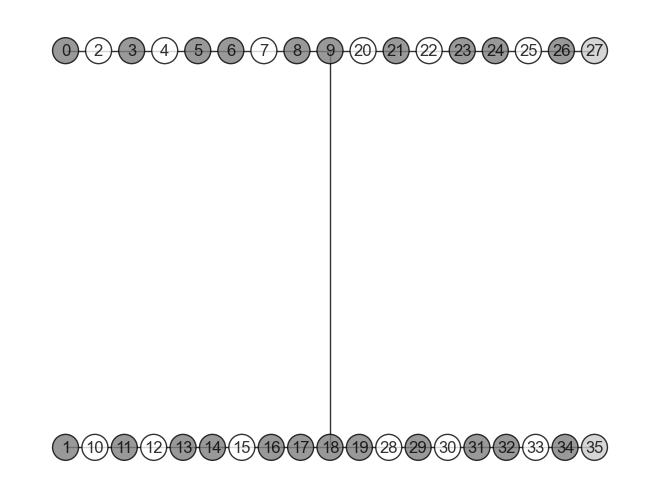

In [11]:
nodes, edges = pattern.get_graph()
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)

from graphix.gflow import flow

f, l_k = flow(g, set(range(n_qubits)), set(pattern.output_nodes))

flow = [[i] for i in range(n_qubits)]
for i in range(n_qubits):
    contd = True
    val = i
    while contd:
        try:
            val = f[val]
            flow[i].append(val)
        except KeyError:
            contd = False
longest = np.max([len(flow[i]) for i in range(n_qubits)])

pos = dict()
for i in range(n_qubits):
    length = len(flow[i])
    fac = longest / (length - 1)
    for j in range(len(flow[i])):
        pos[flow[i][j]] = (fac * j, -i)

# determine wheher or not a node will be measured in Pauli basis
def get_clr_list(pattern):
    nodes, edges = pattern.get_graph()
    meas_list = pattern.get_measurement_commands()
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    clr_list = []
    for i in g.nodes:
        for cmd in meas_list:
            if cmd[1] == i:
                if cmd[3] in [-1, -0.5, 0, 0.5, 1]:
                    clr_list.append([0.5, 0.5, 0.5])
                else:
                    clr_list.append([1, 1, 1])
        if i in pattern.output_nodes:
            clr_list.append([0.8, 0.8, 0.8])
    return clr_list

graph_params = {"with_labels": True,
                "alpha":0.8,
                "node_size": 350,
                "node_color": get_clr_list(pattern),
                "edgecolors": "k"}

nx.draw(g, pos=pos, **graph_params)

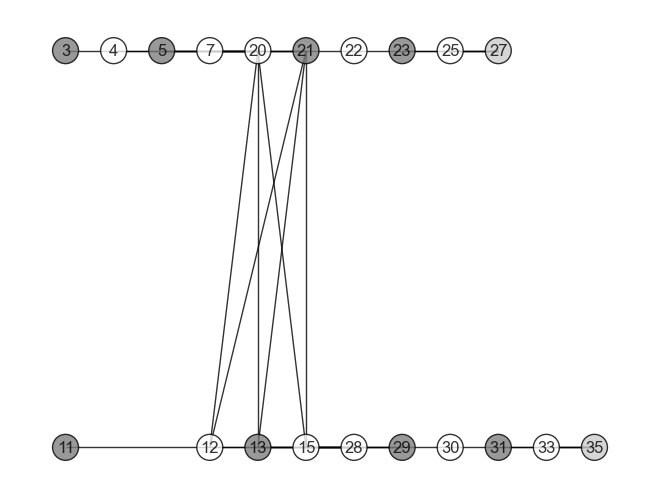

In [12]:
pattern.perform_pauli_measurements()
nodes, edges = pattern.get_graph()
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
graph_params = {"with_labels": True,
                "alpha":0.8,
                "node_size": 350,
                "node_color": get_clr_list(pattern),
                "edgecolors": "k"}

pos = { # hand-typed for better look
    3: (0,0),
    4: (1,0),
    5: (2,0),
    7: (3,0),
    11: (0,-1),
    12: (3,-1),
    13: (4,-1),
    15: (5,-1),
    20: (4,0),
    21: (5,0),
    22: (6,0),
    23: (7,0),
    25: (8,0),
    27: (9,0),
    28: (6,-1),
    29: (7,-1),
    30: (8,-1),
    31: (9,-1),
    33: (10,-1),
    35: (11,-1),
}

nx.draw(g, pos=pos, **graph_params)

In [13]:
qubits = range(1, 10)
n_layers = 2
n_features = 3
input_params = np.random.rand(n_features)

before_meas = []
after_meas = []

for n_qubits in qubits:

    params = np.random.rand(n_layers * n_qubits * n_features * 2)
    qnn = QNN(n_qubits, n_layers, n_features)
    circuit = qnn.data_reuploading_circuit(input_params, params)
    pattern = circuit.transpile()
    pattern.standardize()
    pattern.shift_signals()

    before_meas.append(pattern.max_space())

    pattern.perform_pauli_measurements()
    after_meas.append(pattern.max_space())

    del circuit, pattern, qnn, params

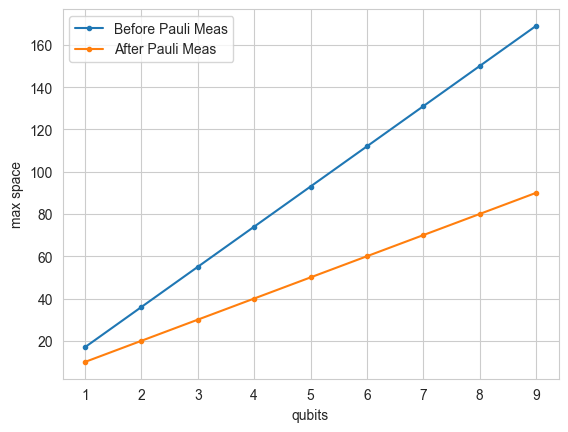

In [15]:
plt.plot(qubits, before_meas, '.-', label='Before Pauli Meas')
plt.plot(qubits, after_meas, '.-', label='After Pauli Meas')
plt.xlabel("qubits")
plt.ylabel("max space")
plt.legend()  # Add a legend to display the labels

plt.show()